In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import keras
import keras.utils

from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
# from keras.callbacks import ModelCheckpoint, EarlyStopping

import time
from keras import metrics

In [18]:
MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat 40 biasanya
MAX_NB_WORDS = 1000 # Vocabulary size
EMBEDDING_DIM = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [19]:
import json
# load data using Python JSON module
with open('dataset/haji_dataset_final_banget.json','r') as f:
    data = json.loads(f.read())
    
# Normalizing data
df = pd.json_normalize(data, record_path =['items'])

In [20]:
df.head()

,labels,questions,answers
0,haji,Apa yang dimaksud ibadah haji?,Ibadah haji ialah berkunjung ke Baitullah (Ka’...
1,haji,Apa hukum ibadah haji dan umrah?,Hukum ibadah haji dan umrah adalah wajib bagi ...
2,haji,Apa setiap ibadah haji harus digabung dengan u...,Ibadah haji dan ibadah umrah merupa- kan 2 (du...
3,haji,Apa yang dimaksud haji tamattu?,Haji tamattu’ ialah melakukan umrah lebih dahu...
4,haji,Apa yang dimaksud haji ifrad?,Haji ifrad ialah melakukan haji saja. Bagi yan...


In [ ]:
# untuk puntuation hanya ' tidak usah ada penghilangan -
# import string
# string.punctuation

# #defining the function to remove punctuation
# def remove_punctuation(text):
#     punctuationfree="".join([i for i in text if i not in string.punctuation])
#     return punctuationfree

In [ ]:
# #storing the puntuation free text
# df['punc']= df['questions'].apply(lambda x:remove_punctuation(x))
# df['punc']

In [21]:
# Preparing question to X
questions = df.questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions)
sequences = tokenizer.texts_to_sequences(questions)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [22]:
# memasukan hasil tokenizer ke dalam X 
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

In [23]:
# Preparing Y
# encode label because label alfabetic
# menjadikan label ke kategorikal
le = LabelEncoder()
label = df.labels
labelEncode = le.fit_transform(label)
y = to_categorical(labelEncode)

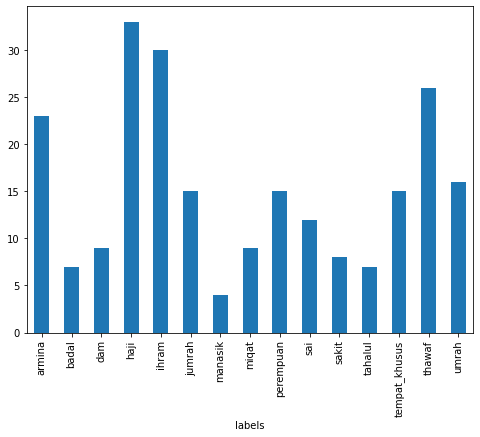

In [24]:
fig = plt.figure(figsize=(8,6))
df.groupby('labels').questions.count().plot.bar(ylim=0)
plt.show()

In [ ]:
# df = preprocess_corpus(df, column='questions')
# df.head()

In [ ]:
# untuk melihat hasi lebel yang telah diencode
list(le.classes_)
# labelEncode

In [ ]:
# Belajar Smote
# from imblearn.over_sampling import SMOTE

In [ ]:
# smote = SMOTE('minority')
# X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [25]:
# bagi data menjadi 2 train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)

In [ ]:

# print("Before OverSampling, counts of label '0': {} \n".format(X.shape))
# print("Before OverSampling, counts of label '0': {} \n".format(y.shape))


In [ ]:
# checkpoint_path = 'data-target-model-wtl.h5'
# early_stopper = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode='auto')
# checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=0, save_best_only=True)

# tinggal memnambahkan callback pada model fit
# untuk menyimpan model terbaik juga

In [26]:
# create model CNN
def build_cnn_model():
    model = Sequential()
    
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH))

    model.add(Conv1D(128, 3, padding='same', activation='relu'))
    # bisa menggunakan 128 atau 65
#     model.add(MaxPooling1D(2))

    model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.25))
    model.add(Flatten())
    
#     model.add(Dense(units=250,activation="relu"))  
    model.add(Dense(15, activation='softmax'))
    
    model.compile(optimizer="adam",metrics=["accuracy"],loss="categorical_crossentropy")

    model.summary()
    return model

In [27]:
# Train Model
cnn_model = build_cnn_model()
cnn_history = cnn_model.fit(X_train,y_train,epochs=30,validation_data=(X_test, y_test))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           41300     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 128)           38528     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1935      
Total params: 81,763
Trainable params: 81,763
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5/5 [==============================] - 1s 65ms/step - loss: 2.6940 - accuracy: 0.0889 - val_loss: 2.6630 

In [ ]:
# save model cnn
# cnn_model.save('cnn_model_test.h5')

In [ ]:
# load model
# from keras.models import load_model

# new_model = load_model('cnn_model.h5')

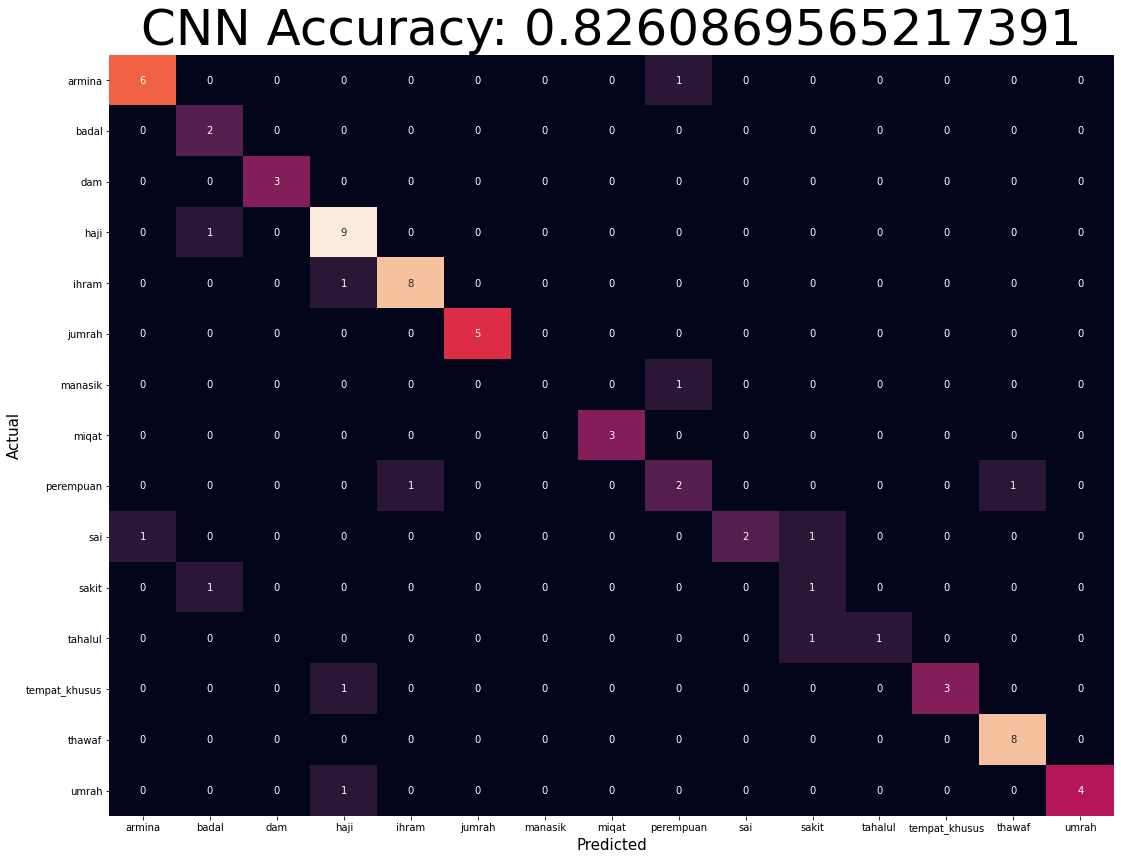

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
#print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
plt.subplots(figsize=(18,14))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cbar=False,xticklabels=le.classes_,yticklabels=le.classes_)
plt.title("CNN Accuracy: {}".format(cnn_accuracy),fontsize=50)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
plt.show()

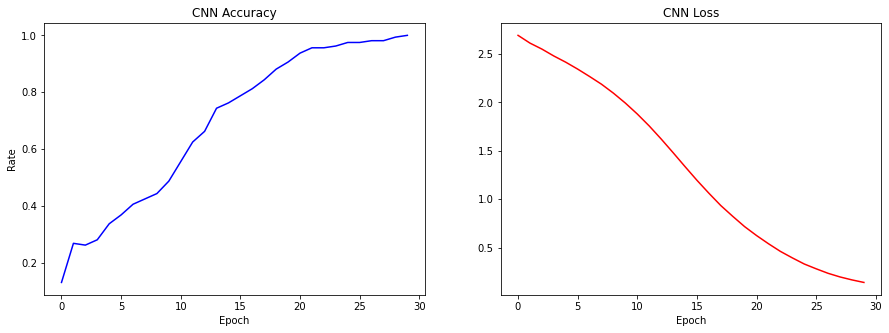

In [29]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy",color="blue")
axe1[1].plot(cnn_history.history["loss"],label="loss",color="red")
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()

In [ ]:
from rake_nltk import Rake, Metric
from collections import Counter
import math

r = Rake(language="indonesian", min_length=1, max_length=5)

def counter(quest):
    counter = Counter(quest)
    return counter

def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

def cnn_predict(quest):
    puretext = tokenizer.texts_to_sequences(quest)
    text_pad = pad_sequences(puretext,maxlen=50,padding='post')
    predicted = cnn_model.predict(text_pad)
    predicted_category = predicted.argmax(axis=1)
    return le.classes_[predicted_category]

def get_df(labels):
    dfNews = df.loc[df['labels'] == labels]
    npQuestions = dfNews.questions.to_numpy()
    npAnswers = dfNews.answers.to_numpy()
    return npQuestions,npAnswers

def rake_question(npQuestions, questUser):
    tempRake = []
    for i in range(len(npQuestions)):
        r.extract_keywords_from_text(npQuestions[i])
        tempRake.append(r.get_ranked_phrases())
    r.extract_keywords_from_text(questUser[0])
    qRake = r.get_ranked_phrases()
    return tempRake, qRake
    
def counter_result(tempRake, qRake):
    tempCounter = []
    for i in range(len(tempRake)):
        tempCounter.append(counter(tempRake[i]))
    counterQuestUser = counter(qRake)
    return tempCounter, counterQuestUser

def score_cosine(tempCounter, counterQuestUser):
    scoresCosine = []
    for i in range(len(tempCounter)):
        scoresCosine.append(counter_cosine_similarity(counterQuestUser, tempCounter[i]) * 100)
    npScore = np.array(scoresCosine)
    maxScore = np.amax(npScore)
    indexQuest = np.argmax(npScore)apa saja sunah haji?
    return maxScore, indexQuest

In [ ]:
questUser = ['kapan kegiatan manasik umrah dilakukan?']

label = cnn_predict(questUser)
# npQuestion , npAnswer = get_df(label[0])
# tempRake, qRake = rake_question(npQuestion, questUser)
# tempCounter, counterQuestUser = counter_result(tempRake, qRake)
# maxScore, indexQuest = score_cosine(tempCounter, counterQuestUser)

print("label: " + label[0])
# print("MaxScore " + str(maxScore))
# print("prediksi question = " + npQuestion[indexQuest])
# print("prediksi Answer = " + npAnswer[indexQuest])

batas

In [ ]:
# Mengambil data frame yg question
dfNew = df.loc[df['labels'] == 'investasi']

Menngunakan Rake untuk mencari jawaban

In [ ]:
# algoritma MIT Licesence https://github.com/csurfer/rake-nltk
from rake_nltk import Rake, Metric

TO CONTROL STOPWORD

    r = Rake(
        stopwords=<list of stopwords>,
        punctuations=<string of puntuations to ignore>
    )
    
TO CONTROL METRIC FOR RANKING

    # Paper uses d(w)/f(w) as the final metric. You can use this API with the
    # following metrics:

    # 1. d(w)/f(w) (Default metric) Ratio of degree of word to its frequency.
    r = Rake(ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)

    # 2. d(w) Degree of word only.
    r = Rake(ranking_metric=Metric.WORD_DEGREE)

    # 3. f(w) Frequency of word only.
    r = Rake(ranking_metric=Metric.WORD_FREQUENCY)
 
TO CONTROL THE MAX OR MIN WORDS IN A PHARSE

    r = Rake(min_length=2, max_length=4)


In [ ]:
# fungsi stopword indonesia
r = Rake(language="indonesian", min_length=1, max_length=5)

In [ ]:
# testing rake
textsu = "Bagaimana bentuk kegiatan operasional Bank Syariah?"
r.extract_keywords_from_text(textsu)
r.get_ranked_phrases_with_scores()

Merubah question ke bentuk rake dan masukan kedalam list https://stackoverflow.com/questions/55162668/calculate-similarity-between-list-of-words

In [ ]:
npQuestions = dfNew.questions.to_numpy()
npAnswers = dfNew.answers.to_numpy()

In [ ]:
# mencari keyword di setiap list pertanyaan
tempRake = []
for i in range(len(npQuestions)):
    r.extract_keywords_from_text(npQuestions[i])
    tempRake.append(r.get_ranked_phrases())

In [ ]:
# Mencari keyword question yang diajukan user
# questUser = "Apa ciri-ciri bank Syariah?"
r.extract_keywords_from_text(questUser[0])
qRake = r.get_ranked_phrases()

In [ ]:
# Menghitung Cosine Similiarity
from collections import Counter
import math

def counter(quest):
    counter = Counter(quest)
    return counter

def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

In [ ]:
counterQuestUser = counter(qRake)

In [ ]:
tempCounter = []
for i in range(len(tempRake)):
    tempCounter.append(counter(tempRake[i]))

In [ ]:
scoresCosine = []
for i in range(len(tempCounter)):
    scoresCosine.append(counter_cosine_similarity(counterQuestUser, tempCounter[i]) * 100)

In [ ]:
npScore = np.array(scoresCosine)
maxScore = np.amax(npScore)
indexQuest = np.argmax(npScore)

In [ ]:
print("prediksi question = " + npQuestions[indexQuest])
print("prediksi Answer = " + npAnswers[indexQuest])

Menghitung hasil dari Accuracy dan Precision dari Model CNN

In [ ]:
predictions = cnn_model.predict(X_test)
predictions = [np.argmax(predictions[i]) for i in range(len(predictions))]
predictions = np.array(predictions)
labels = [np.argmax(y_test[i]) for i in range(len(y_test))]
labels = np.array(labels)

In [ ]:
from sklearn import metrics

print ("Accuracy: " + str(100*metrics.accuracy_score(labels, predictions)))
print ("Precision: " + str(100*metrics.precision_score(labels, predictions, average="weighted")))
print ("Recall: " + str(100*metrics.recall_score(labels, predictions, average="weighted")))
print ("f1_score: " + str(100*metrics.f1_score(labels, predictions, average="weighted")))